In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import os

import json
import gzip

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from network.model import NerFormer
from network.feature_network import FeatureNet
from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from point_sampling import *
from dataloader.co3d_utils import *

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [5]:
seq_imgs, seq_masks, seq_c2ws, seq_intrinsics = read_seq_data("./test_dataset/38_1655_5016", normalization=True)

print(len(seq_imgs), len(seq_masks), len(seq_c2ws), len(seq_intrinsics))

print(seq_imgs[0])
print(seq_masks[0])
print(seq_c2ws[0])
print(seq_intrinsics[0])

102 102 102 102
teddybear/38_1655_5016/images/frame000001.jpg
teddybear/38_1655_5016/masks/frame000001.png
tensor([[-0.9966, -0.0065,  0.0825, -0.0521],
        [ 0.0041, -0.9996, -0.0289, -0.5714],
        [ 0.0826, -0.0285,  0.9962, -0.6688],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[523.4543,   0.0000, 239.5000,   0.0000],
        [  0.0000, 294.0334, 179.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]])


In [6]:
seq_imgs, seq_masks, seq_c2ws_unscaling, seq_intrinsics = read_seq_data("./test_dataset/38_1655_5016", normalization=False)

print(len(seq_imgs), len(seq_masks), len(seq_c2ws_unscaling), len(seq_intrinsics))

print(seq_imgs[0])
print(seq_masks[0])
print(seq_c2ws_unscaling[0])
print(seq_intrinsics[0])

102 102 102 102
teddybear/38_1655_5016/images/frame000001.jpg
teddybear/38_1655_5016/masks/frame000001.png
tensor([[-9.9657e-01, -6.4938e-03,  8.2491e-02, -3.2220e-01],
        [ 4.1219e-03, -9.9957e-01, -2.8891e-02,  1.4834e+00],
        [ 8.2644e-02, -2.8452e-02,  9.9617e-01, -6.3846e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[523.4543,   0.0000, 239.5000,   0.0000],
        [  0.0000, 294.0334, 179.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]])


x : max = 0.971941351890564, min = -0.9832789301872253
y : max = 0.8142796754837036, min = -0.7478426694869995
z : max = 0.5920737981796265, min = -0.6687561869621277


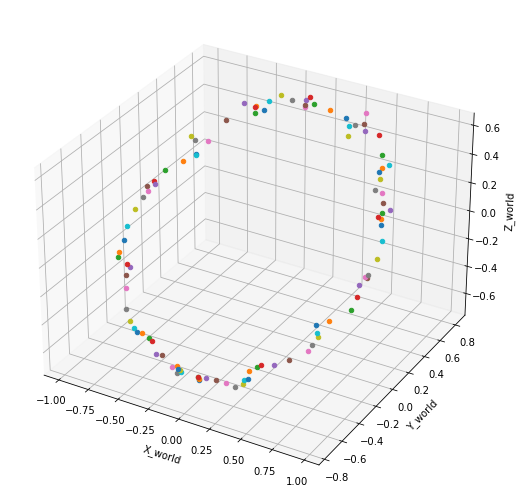

In [7]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points
xs = []
ys = []
zs = []

for seq_c2w in seq_c2ws:
    x, y, z = seq_c2w[:3, 3].numpy()
    xs.append(x)
    ys.append(y)
    zs.append(z)

    ax.scatter3D(x, y, z, cmap='Greens')

print(f"x : max = {max(xs)}, min = {min(xs)}")
print(f"y : max = {max(ys)}, min = {min(ys)}")
print(f"z : max = {max(zs)}, min = {min(zs)}")

x : max = 2.739812135696411, min = -3.1067631244659424
y : max = 5.627035140991211, min = 0.9559166431427002
z : max = -2.6144509315490723, min = -6.384633541107178


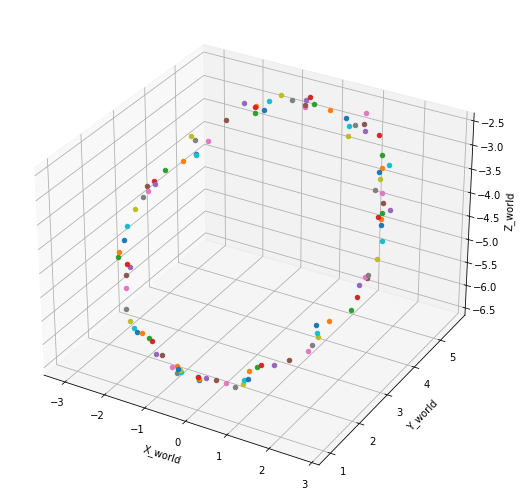

In [8]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points
xs = []
ys = []
zs = []

for seq_c2w in seq_c2ws_unscaling:
    x, y, z = seq_c2w[:3, 3].numpy()
    xs.append(x)
    ys.append(y)
    zs.append(z)

    ax.scatter3D(x, y, z, cmap='Greens')

print(f"x : max = {max(xs)}, min = {min(xs)}")
print(f"y : max = {max(ys)}, min = {min(ys)}")
print(f"z : max = {max(zs)}, min = {min(zs)}")

In [ ]:
category_imgs, _, _, _ = read_category_data("D:/CO3D/teddybear", normalization=False)

print(category_imgs[:10])

In [6]:
index = 500
seq_name = '/'.join(category_imgs[index].split('/')[:2])
print(seq_name)

_, _, seq_c2ws, _ = read_seq_data("D:/CO3D/" + seq_name, normalization=False)

teddybear/374_41889_83845


/var/folders/cw/qtbgk9491qggm1gdsn7pbwqr0000gn/T/ipykernel_8615/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


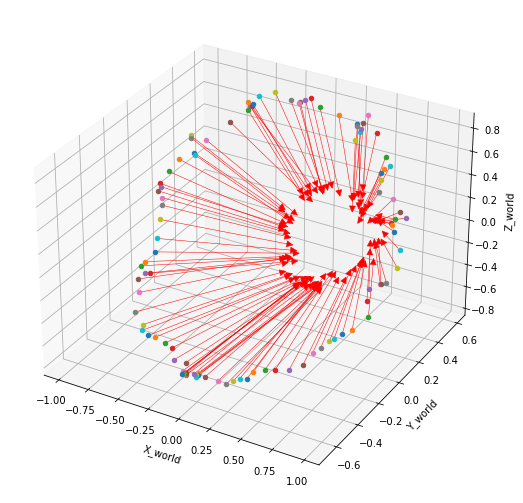

In [9]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points

for seq_c2w in seq_c2ws:
    x, y, z = seq_c2w[:3, 3].numpy()
    zx, zy, zz = seq_c2w[:3, 2].numpy()
    
    xs = [x, x+zx]
    ys = [y, y+zy]
    zs = [z, z+zz]
    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    ax.scatter3D(x, z, y, cmap='Greens')

***

# c2w 계산 과정 확인
Rotation과 Translation 값을 가지고 [ R | t ] 형태로 만든 것을 w2c로 정의.

c2w를 계산하기 위해

- w2c를 바로 inverse 시킨 값
- R^-1 = R^T, t^-1 = R^T x (-t)  ------> [ R^(-1) | t^(-1) ]

두 값이 동일한지 확인

In [8]:
with open("./test_dataset/38_1655_5016/frame_annotations_file.json", 'r') as f:
    j = json.load(f)

frame = j[0]

for frame_key in frame.keys():
    print(frame_key, frame[frame_key])

frame_number 0
frame_timestamp -1.0
image {'path': 'teddybear/38_1655_5016/images/frame000001.jpg', 'size': [479, 359]}
depth {'path': 'teddybear/38_1655_5016/depths/frame000001.jpg.geometric.png', 'scale_adjustment': 1.262808918952942, 'mask_path': 'teddybear/38_1655_5016/depth_masks/frame000001.png'}
mask {'path': 'teddybear/38_1655_5016/masks/frame000001.png', 'mass': 35984.0}
viewpoint {'R': [[-0.9965706467628479, 0.004121924750506878, 0.08264364302158356], [-0.006493818014860153, -0.9995740652084351, -0.028452031314373016], [0.08249115943908691, -0.028891131281852722, 0.9961729049682617]], 'T': [0.20043912529945374, 1.2990046739578247, 6.429634094238281], 'focal_length': [2.1856130105871343, 1.6380690413377479], 'principal_point': [0.0, 0.0]}


In [9]:
c2w, k = get_c2w_intrinsic(frame["image"]["size"], frame["viewpoint"])

r = torch.eye(3)
r[:3, :3] = torch.tensor(frame["viewpoint"]["R"], dtype=torch.float)

t = torch.tensor(frame["viewpoint"]["T"], dtype=torch.float).reshape((3, 1))

In [11]:
print(c2w)
print(r)
print(t)

print(k)

tensor([[-9.9657e-01,  6.4938e-03, -8.2491e-02, -3.2220e-01],
        [ 4.1219e-03,  9.9957e-01,  2.8891e-02,  1.4834e+00],
        [ 8.2644e-02,  2.8452e-02, -9.9617e-01, -6.3846e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-0.9966,  0.0041,  0.0826],
        [-0.0065, -0.9996, -0.0285],
        [ 0.0825, -0.0289,  0.9962]])
tensor([[0.2004],
        [1.2990],
        [6.4296]])
tensor([[523.4543,   0.0000, 239.5000,   0.0000],
        [  0.0000, 294.0334, 179.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]])


In [12]:
r_T = r.T
print("inverse rotation (R^T) : \n", r_T)

t_T = r_T.matmul(-t)
print("\ninverse translation (R^T x -t) : \n", t_T, t_T.shape)

c2w_2 = torch.eye(4, dtype=torch.float)
c2w_2[:3, :3] = r_T
c2w_2[:3, 3] = t_T.T
print(c2w_2)

print("c2w ([R^T | t]): \n", c2w)

inverse rotation (R^T) : 
 tensor([[-0.9966, -0.0065,  0.0825],
        [ 0.0041, -0.9996, -0.0289],
        [ 0.0826, -0.0285,  0.9962]])

inverse translation (R^T x -t) : 
 tensor([[-0.3222],
        [ 1.4834],
        [-6.3846]]) torch.Size([3, 1])
tensor([[-9.9657e-01, -6.4938e-03,  8.2491e-02, -3.2220e-01],
        [ 4.1219e-03, -9.9957e-01, -2.8891e-02,  1.4834e+00],
        [ 8.2644e-02, -2.8452e-02,  9.9617e-01, -6.3846e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
c2w ([R^T | t]): 
 tensor([[-9.9657e-01,  6.4938e-03, -8.2491e-02, -3.2220e-01],
        [ 4.1219e-03,  9.9957e-01,  2.8891e-02,  1.4834e+00],
        [ 8.2644e-02,  2.8452e-02, -9.9617e-01, -6.3846e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [13]:
w2c = torch.eye(4, dtype=torch.float)

w2c[:3, :3] = r
w2c[:3, 3] = t.T

print("w2c (= [R | t]) : \n", w2c)
print("\nc2w (= [R | t]^-1) : \n", torch.inverse(w2c))

w2c (= [R | t]) : 
 tensor([[-9.9657e-01,  4.1219e-03,  8.2644e-02,  2.0044e-01],
        [-6.4938e-03, -9.9957e-01, -2.8452e-02,  1.2990e+00],
        [ 8.2491e-02, -2.8891e-02,  9.9617e-01,  6.4296e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

c2w (= [R | t]^-1) : 
 tensor([[-9.9657e-01, -6.4938e-03,  8.2491e-02, -3.2220e-01],
        [ 4.1219e-03, -9.9957e-01, -2.8891e-02,  1.4834e+00],
        [ 8.2644e-02, -2.8452e-02,  9.9617e-01, -6.3846e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [14]:
P_w = torch.tensor([10, 20, 30, 1], dtype=torch.float)
P_c = w2c.matmul(P_w)
P_c_2_w = c2w.matmul(P_c)

print(f"P_world : \n{P_w} \n\nP_camera = w2c(P_world) : \n{P_c} \n\nP_camera convert back to wrold = c2w(P_camera) : \n{P_w}")

P_world : 
tensor([10., 20., 30.,  1.]) 

P_camera = w2c(P_world) : 
tensor([ -7.2035, -19.6110,  36.5619,   1.0000]) 

P_camera convert back to wrold = c2w(P_camera) : 
tensor([10., 20., 30.,  1.])


***

# NeRF llff 데이터셋에서의 bounds 값

In [10]:
nerf_llff_bds = np.load("./poses_bounds.npy")

In [28]:
print(len(nerf_llff_bds))
print(len(nerf_llff_bds[0]))
print(nerf_llff_bds[0])

llff_poses = nerf_llff_bds[:, :-2].reshape([-1, 3, 5]).transpose([1, 2, 0])
print(llff_poses.shape)
llff_bds = nerf_llff_bds[:, -2:].transpose([1, 0])
print(llff_bds.shape)
print(llff_poses[..., 0], '\n')
print(llff_poses[:3, :4, 0], '\n')
print(llff_poses[:3, 4, 0], '\n')
print(llff_bds[:, 0], '\n')

55
17
[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
  3.02400000e+03  9.99658714e-01 -1.19034697e-02 -2.32542981e-02
 -3.09885180e+00  4.03200000e+03 -2.39263938e-02 -5.98369192e-02
 -9.97921375e-01  4.17063527e-02  3.32986996e+03  2.94571964e+01
  1.14827880e+02]
(3, 5, 55)
(2, 55)
[[ 1.04872613e-02  9.98137190e-01 -6.01013048e-02 -3.37871546e+00
   3.02400000e+03]
 [ 9.99658714e-01 -1.19034697e-02 -2.32542981e-02 -3.09885180e+00
   4.03200000e+03]
 [-2.39263938e-02 -5.98369192e-02 -9.97921375e-01  4.17063527e-02
   3.32986996e+03]] 

[[ 0.01048726  0.99813719 -0.0601013  -3.37871546]
 [ 0.99965871 -0.01190347 -0.0232543  -3.0988518 ]
 [-0.02392639 -0.05983692 -0.99792138  0.04170635]] 

[3024.         4032.         3329.86995717] 

[ 29.45719638 114.82787963] 



***

# Ray sampling 테스트

In [10]:
# 배치 사이즈를 1로 설정하여 테스트
c2w_ = seq_c2ws[0].unsqueeze(0)
intrinsic_ = seq_intrinsics[0].unsqueeze(0)

In [10]:
cam_idx = 0

tgt_img_path = seq_imgs[cam_idx]
tgt_img = Image.open("./test_dataset/" + '/'.join(tgt_img_path.split('/')[1:])).resize((360, 480))


# 배치 사이즈를 1로 설정하여 테스트
c2w_ = seq_c2ws[cam_idx].unsqueeze(0)
intrinsic_ = seq_intrinsics[cam_idx].unsqueeze(0)
depth_range = torch.tensor([0.2, 1.8], dtype=torch.float)
device = "cpu"

data = {"rgb_path": seq_imgs[cam_idx],
        "camera": c2w_,
        "depth_range": depth_range}

N_samples = 20

In [11]:
ray_sampler = RaySampler(data, device, tgt_img.height, tgt_img.width, intrinsic_, c2w_)

In [12]:
sample_rays = ray_sampler.random_sample(N_samples, "center")

In [17]:
sample_rays["depth_range"]

tensor([0.2000, 1.8000])

In [42]:
print(sample_rays["ray_d"][:5])
print(sample_rays["ray_o"][:5])

ray_idx = 5
ray_d = sample_rays["ray_d"][ray_idx]
ray_o = sample_rays["ray_o"][ray_idx]
print(ray_d)
print(ray_o)

N_points = 20
sample_points, sample_z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), depth_range.unsqueeze(0), N_points)

tensor([[ 0.2574, -0.7996,  0.9593],
        [ 0.3933, -0.0999,  0.9684],
        [ 0.4551, -0.8412,  0.9418],
        [ 0.4259, -0.3618,  0.9581],
        [ 0.3950, -0.1271,  0.9674]])
tensor([[-0.0521, -0.5714, -0.6688],
        [-0.0521, -0.5714, -0.6688],
        [-0.0521, -0.5714, -0.6688],
        [-0.0521, -0.5714, -0.6688],
        [-0.0521, -0.5714, -0.6688]])
tensor([ 0.2302, -0.2998,  0.9761])
tensor([-0.0521, -0.5714, -0.6688])


In [40]:
sample_points.shape

torch.Size([1, 20, 3])

[-0.052061524242162704, 0.23018643260002136] [-0.5714460611343384, -0.29977160692214966] [-0.6687561869621277, 0.9760864973068237]


/var/folders/cw/qtbgk9491qggm1gdsn7pbwqr0000gn/T/ipykernel_8615/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


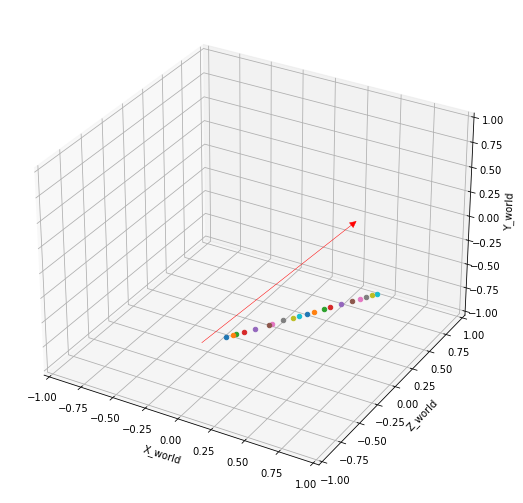

In [41]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

print(xs, ys, zs)
a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sample_points[0]:
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

In [16]:
# 테스트 이미지의 크기 지정
W = 10
H = 20
u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]
pixels = torch.from_numpy(pixels)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

# 각 픽셀로 향하는 rays의 방향을 구함
rays_d = (c2w_[:, :3, :3].bmm(torch.inverse(intrinsic_[:, :3, :3])).bmm(batched_pixels)).transpose(1, 2)
rays_d = rays_d.reshape(-1, 3)

# 각 픽셀로 향하는 rays의 원점을 구함
rays_o = c2w_[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)  # B x HW x 3

In [17]:
pixels[:, :10]

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [18]:
print(f"rays_d : \n{rays_d[:10]} \nrays_o : \n{rays_o[:10]}")

rays_d : 
tensor([[ 0.4601, -0.6052, -1.0020],
        [ 0.4582, -0.6052, -1.0020],
        [ 0.4563, -0.6052, -1.0020],
        [ 0.4544, -0.6052, -1.0020],
        [ 0.4525, -0.6052, -1.0020],
        [ 0.4506, -0.6052, -1.0020],
        [ 0.4487, -0.6052, -1.0020],
        [ 0.4468, -0.6052, -1.0021],
        [ 0.4449, -0.6052, -1.0021],
        [ 0.4430, -0.6052, -1.0021]]) 
rays_o : 
tensor([[-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957],
        [-0.2913,  0.7838, -6.7957]])


***

# Positional Embedding 결과 확인

In [19]:
# (x, y, z) ---> 3(x, y, z) * 2(sin, cos) * 10 = 60으로 변환
pe = HarmonicEmbedding(10)

pe_test = pe(torch.tensor([0, 0, 1]))
print(pe_test)
print(pe_test.shape)

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0998,  0.1987,  0.3894,  0.7174,
         0.9996, -0.0584,  0.1165,  0.2315,  0.4504,  0.8043,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  0.9950,  0.9801,  0.9211,  0.6967, -0.0292, -0.9983,
         0.9932,  0.9728,  0.8928,  0.5942])
torch.Size([60])


-0.32220075 -0.32220075
1.4833846 1.4833846
-6.3846335 -6.3846335


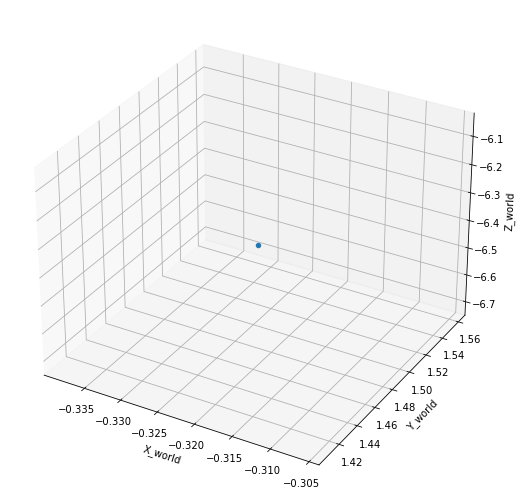

In [11]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Y_world")
ax.set_zlabel("Z_world")
# ax.set_xlim3d(-1, 1)
# ax.set_ylim3d(-1, 1)
# ax.set_zlim3d(-1, 1)

# Data for three-dimensional scattered points
xs = []
ys = []
zs = []

for i, seq_c2w in enumerate(seq_c2ws):
    if (i == 0):
        x, y, z = seq_c2w[:3, 3].numpy()
        xs.append(x)
        ys.append(y)
        zs.append(z)

        ax.scatter3D(x, y, z, cmap='Greens')

print(max(xs), min(xs))
print(max(ys), min(ys))
print(max(zs), min(zs))

# 카메라 좌표축에서의 ray와 sampling 시각화 (transform 이전)

In [43]:
W = 640
H = 380
u, v = np.meshgrid(np.arange(W), np.arange(H))

# 이미지의 각 row들이 한 줄로 이어붙은 형태로 변환
# (H, W) --> (H*W)
u = u.reshape(-1).astype(dtype=np.float32)  # + 0.5    # add half pixel
v = v.reshape(-1).astype(dtype=np.float32)  # + 0.5

pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # [3(x+y+z), H*W]? 아니면 homogeneous coordinate라 1을 추가한 건지?
pixels = torch.from_numpy(pixels)
batched_pixels = pixels.unsqueeze(0).repeat(1, 1, 1)

# bmm : batch matrix-matrix product 
# [B, N, M] tensor * [B, M, P] tensor >>> [B, N, P]
rays_d = batched_pixels.transpose(1, 2).reshape(-1, 3)
rays_o = torch.tensor([0, 0, 0]).unsqueeze(0).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)

# plt.figure(figsize=(16, 9))
# ax = plt.axes(projection='3d')
# ax.set_xlabel("X_world")
# ax.set_ylabel("Z_world")
# ax.set_zlabel("Y_world")
# ax.set_xlim3d(-5, 30)
# ax.set_ylim3d(-5, 30)
# ax.set_zlim3d(-5, 30)

# for i, (ray_o, ray_d) in enumerate(zip(rays_o, rays_d)):
#     xs = [ray_o[0].item(), ray_d[0].item()]
#     ys = [ray_o[1].item(), ray_d[1].item()]
#     zs = [ray_o[2].item(), ray_d[2].item()]
#     a = Arrow3D(xs, zs, ys, mutation_scale=15, 
#                     lw=0.5, arrowstyle="-|>", color="r")
#     ax.add_artist(a)
    
# ax.scatter3D(ray_o[0].item(), ray_o[2].item(), ray_o[1].item(), cmap='Greens')

In [44]:
rays_d[:10]

tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.],
        [5., 0., 1.],
        [6., 0., 1.],
        [7., 0., 1.],
        [8., 0., 1.],
        [9., 0., 1.]])

In [45]:
ray_idx = 3
ray_d = rays_d[ray_idx]
ray_o = rays_o[ray_idx]

depth_range = torch.tensor([[0.2, 1.8]], dtype=torch.float)
N_samples = 20
sampling_points, z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                                    depth_range, N_samples, det=True)

/var/folders/cw/qtbgk9491qggm1gdsn7pbwqr0000gn/T/ipykernel_8615/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


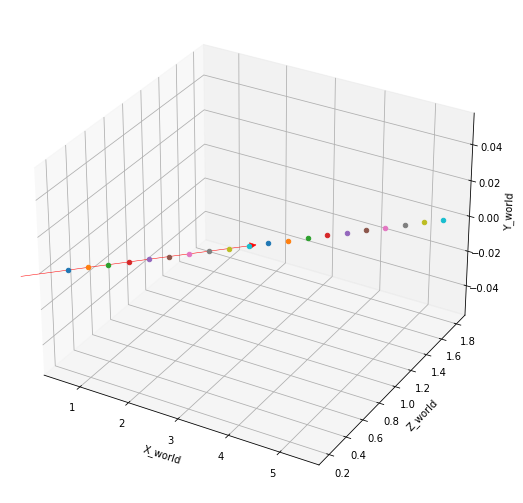

In [46]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sampling_points[0]:
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

# Camera coordinate에서의 rays >>> World coordinate로 transform 시각화

In [47]:
seq_idx = 0

c2w = seq_c2ws[seq_idx].unsqueeze(0)
intrinsic = seq_intrinsics[seq_idx].unsqueeze(0)

print(c2w.shape)
print(intrinsic.shape)
print(rays_d.shape)


############


r_inv = c2w[:, :3, :3].squeeze(0)
t_inv = c2w[:, :3, 3].squeeze(0)
r = r_inv.T
t = r.matmul(-t_inv)

w2c = torch.eye(4, dtype=torch.float).unsqueeze(0)
w2c[:, :3, :3] = r
w2c[:, :3, 3] = t

print(w2c.shape)

torch.Size([1, 4, 4])
torch.Size([1, 4, 4])
torch.Size([243200, 3])
torch.Size([1, 4, 4])


In [48]:
intrinsic[:, :3, :3].matmul(w2c[:, :3, :3]).shape

torch.Size([1, 3, 3])

In [49]:
rays_d_world = (c2w[:, :3, :3].matmul(torch.inverse(intrinsic[:, :3, :3])).matmul(rays_d.transpose(1, 0)))
# rays_d_world = (c2w[:, :3, :3].matmul(rays_d.transpose(1, 0)))
rays_d_world = rays_d_world.transpose(1, 2).reshape(-1, 3)
# rays_size = torch.square(rays_d_world).sum(dim=1).sqrt()
# rays_d_world = rays_d_world.div(rays_size.unsqueeze(1))
        
rays_o_world = c2w[:, :3, 3].unsqueeze(1).repeat(1, rays_d.shape[0], 1).reshape(-1, 3)

print("rays_d in camera coordinate \n", rays_d[:5])
print("\nrays_d in world coordinate \n", rays_d_world[:5])

rays_d_back_2_camera = (intrinsic[:, :3, :3].bmm(w2c[:, :3, :3]).bmm(rays_d_world.unsqueeze(0).transpose(1, 2)))
rays_d_back_2_camera = rays_d_back_2_camera.squeeze(0).transpose(0, 1).round()
print("\nrays_d in camera coordinate again\n", rays_d_back_2_camera[:5])

rays_d in camera coordinate 
 tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.]])

rays_d in world coordinate 
 tensor([[0.5424, 0.5794, 0.9757],
        [0.5405, 0.5794, 0.9759],
        [0.5386, 0.5795, 0.9760],
        [0.5367, 0.5795, 0.9762],
        [0.5348, 0.5795, 0.9764]])

rays_d in camera coordinate again
 tensor([[0., 0., 1.],
        [1., 0., 1.],
        [2., 0., 1.],
        [3., 0., 1.],
        [4., 0., 1.]])


/var/folders/cw/qtbgk9491qggm1gdsn7pbwqr0000gn/T/ipykernel_8615/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


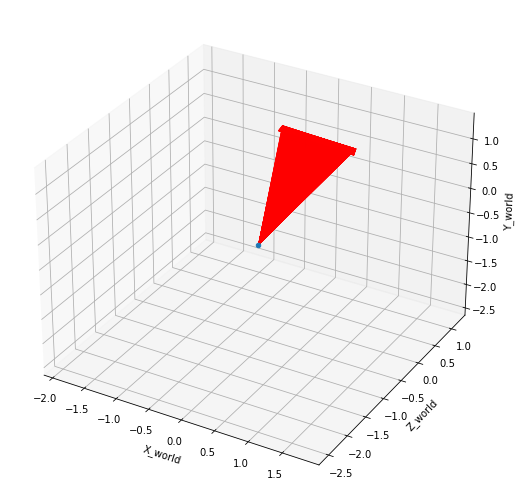

In [50]:
origin = [rays_o_world[0, 0].item(), rays_o_world[0, 1].item(), rays_o_world[0, 2].item()]

plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')

ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")

ax.set_xlim3d(origin[0]-2, origin[0]+2)
ax.set_ylim3d(origin[2]-2, origin[2]+2)
ax.set_zlim3d(origin[1]-2, origin[1]+2)

for i, (ray_o, ray_d) in enumerate(zip(rays_o_world, rays_d_world)):
    xs = [origin[0], ray_d[0].item()]
    ys = [origin[1], ray_d[1].item()]
    zs = [origin[2], ray_d[2].item()]
    a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                    lw=0.5, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    if i == 1000:
        break
    
ax.scatter3D(ray_o[0].item(), ray_o[2].item(), ray_o[1].item(), cmap='Greens')

In [51]:
ray_idx = 3
ray_d = rays_d_world[ray_idx]
ray_o = rays_o_world[ray_idx]

depth_range = torch.tensor([[0.2, 1.8]], dtype=torch.float)
N_samples = 20
sampling_points, z_vals = sample_along_camera_ray(ray_o.unsqueeze(0), ray_d.unsqueeze(0), 
                                                    depth_range, N_samples, det=True)

/var/folders/cw/qtbgk9491qggm1gdsn7pbwqr0000gn/T/ipykernel_8615/1589115755.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


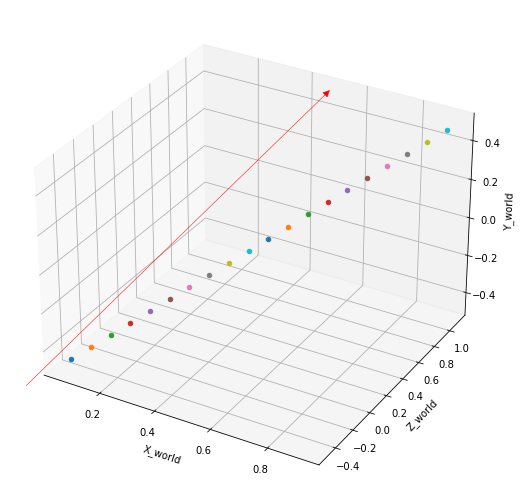

In [52]:
plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
ax.set_xlabel("X_world")
ax.set_ylabel("Z_world")
ax.set_zlabel("Y_world")

xs = [ray_o[0].item(), ray_d[0].item()]
ys = [ray_o[1].item(), ray_d[1].item()]
zs = [ray_o[2].item(), ray_d[2].item()]

a = Arrow3D(xs, zs, ys, mutation_scale=15, 
                lw=0.5, arrowstyle="-|>", color="r")
ax.add_artist(a)

for p in sampling_points[0]:
    x, y, z = p[0].item(), p[1].item(), p[2].item()
    ax.scatter3D(x, z, y, cmap='Greens')

In [104]:
torch.inverse(intrinsic)

tensor([[[ 0.0019,  0.0000, -0.4575, -0.0000],
         [ 0.0000,  0.0034, -0.6105, -0.0000],
         [ 0.0000,  0.0000,  1.0000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])